# OBIS Dataset - Using environmental and temporal features to classify species into IUCN Redlist Categories

## To get the OBIS data set - Download parquet file using link: https://obis.org/data/access/

### Setup

In [1]:
# Importing important libraries
import os, pickle, glob
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
from pyspark.sql import functions as f
from pyspark.sql.window import Window

from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary cache directory at /tmp/matplotlib-p93i1ybx because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Builds the Spark Session
sc = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
	.config("spark.executor.memory", "8g") \
    .config('spark.executor.instances', 15) \
	.getOrCreate()

In [3]:
# Sets up the sql context
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Loading the data

#### Change the path to where you saved your OBIS parquet file

In [4]:
# Loading parquet file 
df = sqlContext.read.load('../obis_20231025.parquet')

In [5]:
# Loading csv file
df_iucn = sqlContext.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('assessments.csv')

In [6]:
# Show the schema for OBIS
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- dataset_id: string (nullable = true)
 |-- decimalLongitude: float (nullable = true)
 |-- decimalLatitude: float (nullable = true)
 |-- date_start: long (nullable = true)
 |-- date_mid: long (nullable = true)
 |-- date_end: long (nullable = true)
 |-- date_year: long (nullable = true)
 |-- scientificName: string (nullable = true)
 |-- originalScientificName: string (nullable = true)
 |-- minimumDepthInMeters: float (nullable = true)
 |-- maximumDepthInMeters: float (nullable = true)
 |-- depth: float (nullable = true)
 |-- coordinateUncertaintyInMeters: float (nullable = true)
 |-- flags: string (nullable = true)
 |-- dropped: boolean (nullable = true)
 |-- absence: boolean (nullable = true)
 |-- shoredistance: string (nullable = true)
 |-- bathymetry: string (nullable = true)
 |-- sst: string (nullable = true)
 |-- sss: string (nullable = true)
 |-- marine: boolean (nullable = true)
 |-- brackish: boolean (nullable = true)
 |-- freshwater: bo

In [7]:
# Show the schema for the IUCN dataset
df_iucn.printSchema()

root
 |-- scientificName: string (nullable = true)
 |-- redlistCategory: string (nullable = true)
 |-- assessmentDate: string (nullable = true)



### Data Exploration

#### Distinct Observations per year

In [8]:
# Aggregates counts for distinct dates
df_dates = df.groupBy(df.date_year).agg({'date_year':'count'}).sort(df.date_year).cache()

In [9]:
# Renames column
df_dates = df_dates.withColumnRenamed('count(date_year)','obs_per_year')

In [10]:
# Shows date counts
df_dates.show()

+---------+------------+
|date_year|obs_per_year|
+---------+------------+
|     NULL|           0|
|      201|           1|
|      931|           1|
|      941|           1|
|      966|           1|
|     1064|           2|
|     1071|           2|
|     1073|           2|
|     1076|           1|
|     1103|           1|
|     1104|           1|
|     1116|           2|
|     1119|           2|
|     1193|           1|
|     1199|           4|
|     1200|           1|
|     1291|           1|
|     1520|           1|
|     1526|           1|
|     1596|           1|
+---------+------------+
only showing top 20 rows



In [11]:
# Converts pyspark df to pandas df
pandas_df_dates = df_dates.toPandas()

In [12]:
# Filtering out dates below 1899 
pandas_df_dates_cut = pandas_df_dates[pandas_df_dates.date_year > 1899]

Text(0, 0.5, 'Observations(per 10 million)')

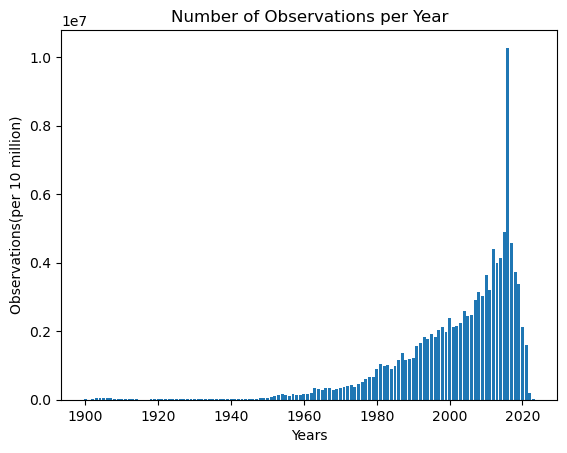

In [13]:
# Plots out counts per year
plt.bar(pandas_df_dates_cut.date_year,pandas_df_dates_cut.obs_per_year)
plt.title("Number of Observations per Year")
plt.xlabel("Years")
plt.ylabel("Observations(per 10 million)")

#### Distinct IUCN classification by Species 

In [14]:
# Distinct counts of species 
df.select("scientificName","redlist_category").filter(df.scientificName != "").filter(df.redlist_category != "").distinct().count()

1979

In [15]:
# Grabs the distinct scientificNames and their redlist categories
df_redlist_distinct = df.select("scientificName","redlist_category").filter(df.scientificName != "").filter(df.redlist_category != "").distinct().cache()

In [16]:
# IUCN classification by species 
df_redlist_distinct.show()

+--------------------+----------------+
|      scientificName|redlist_category|
+--------------------+----------------+
|  Glaucostegus typus|              CR|
|Echinopelta fistu...|              NT|
|   Hippocampus comes|              VU|
|Diplobatis colomb...|              VU|
|Eretmochelys imbr...|              CR|
|Pterodroma arminj...|              VU|
|  Porites nigrescens|              VU|
|  Squalus montalbani|              VU|
|   Ecsenius randalli|              VU|
|   Leptastrea bottae|              NT|
|    Dialommus fuscus|              VU|
|       Oxyura maccoa|              EN|
|Glaucostegus gran...|              CR|
|  Centrophorus uyato|              EN|
|Argyrosomus inodorus|              VU|
|Caulastraea echin...|              VU|
|   Alveopora viridis|              NT|
|    Calidris pusilla|              NT|
|   Hippocampus reidi|              NT|
|    Leptoria phrygia|              NT|
+--------------------+----------------+
only showing top 20 rows



In [17]:
# Aggregates based on redlist groups
df_redlist_count = df_redlist_distinct.select("redlist_category").groupBy("redlist_category").agg({'redlist_category':'count'})

In [18]:
# Renames columns
df_redlist_count = df_redlist_count.withColumnRenamed('count(redlist_category)','obs_per_cat')

In [19]:
# Count of unique redlist categorized species
df_redlist_count.show()

+----------------+-----------+
|redlist_category|obs_per_cat|
+----------------+-----------+
|              EX|          8|
|              NT|        562|
|           LR/nt|          5|
|              EN|        371|
|              CR|        225|
|           LR/cd|          5|
|              EW|          1|
|              VU|        802|
+----------------+-----------+



In [20]:
# Converts pyspark df to pandas df
pandas_redlist_count = df_redlist_count.toPandas()

Text(0, 0.5, 'Number of species')

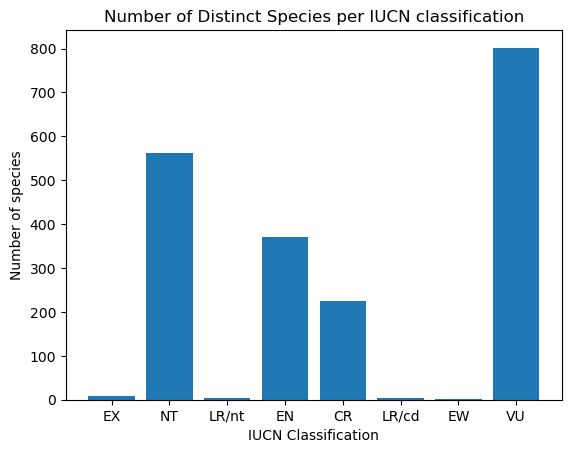

In [21]:
# Plots out uniqe redlist category counts per year
plt.bar(pandas_redlist_count.redlist_category,pandas_redlist_count.obs_per_cat)
plt.title("Number of Distinct Species per IUCN classification")
plt.xlabel("IUCN Classification")
plt.ylabel("Number of species")

#### Orca observations over time

In [22]:
# Creates df that checks orca sightings per year via aggregation
df_orca = df.filter(df.scientificName == "Orcinus orca").select("date_year").groupBy("date_year").agg({'date_year':'count'}).sort("date_year").cache()

In [23]:
# Renames column
df_orca = df_orca.withColumnRenamed('count(date_year)','obs_per_year')

In [24]:
# Shows orca sightings per year
df_orca.show()

+---------+------------+
|date_year|obs_per_year|
+---------+------------+
|     NULL|           0|
|     1758|           4|
|     1822|           2|
|     1824|           1|
|     1844|           1|
|     1848|           1|
|     1866|           2|
|     1871|           1|
|     1872|           1|
|     1884|           1|
|     1894|           1|
|     1910|           2|
|     1911|           8|
|     1912|           6|
|     1913|           2|
|     1916|           1|
|     1918|           3|
|     1920|           1|
|     1921|           1|
|     1924|           2|
+---------+------------+
only showing top 20 rows



In [25]:
# Converts pyspark df to pandas df
pandas_orca = df_orca.toPandas()

Text(0, 0.5, 'Number of observations')

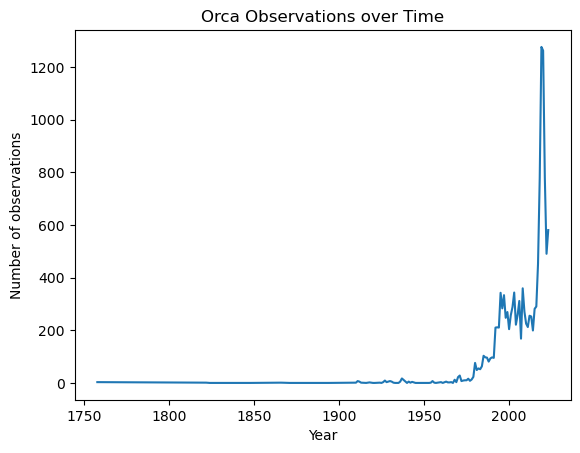

In [26]:
# Plots out orca sightings per year
plt.plot(pandas_orca.date_year,pandas_orca.obs_per_year)
plt.title("Orca Observations over Time")
plt.xlabel("Year")
plt.ylabel("Number of observations")

#### Null Counts

In [27]:
# Null Counts
null_counts = df.select([f.sum(f.col(column).isNull().cast("int")).alias(column) for column in df.columns])
null_counts_dict = null_counts.collect()[0].asDict()
null_counts_df = sc.createDataFrame(null_counts_dict.items(), ["column_name", "null_count"])
num_rows = null_counts_df.count()
null_counts_df.show(num_rows, truncate=False)

+-----------------------------------+----------+
|column_name                        |null_count|
+-----------------------------------+----------+
|id                                 |0         |
|dataset_id                         |0         |
|decimalLongitude                   |0         |
|decimalLatitude                    |0         |
|date_start                         |5113635   |
|date_mid                           |5113635   |
|date_end                           |5113635   |
|date_year                          |5113635   |
|scientificName                     |14785     |
|originalScientificName             |43072     |
|minimumDepthInMeters               |55961796  |
|maximumDepthInMeters               |52565014  |
|depth                              |50283294  |
|coordinateUncertaintyInMeters      |63710247  |
|flags                              |178       |
|dropped                            |0         |
|absence                            |0         |
|shoredistance      

### Preprocessing

#### OBIS Aggregation

In [28]:
# Selecting important columns
df_trim_col = df.select(
    'id',
    'decimalLongitude',
    'decimalLatitude',
    'date_year',
    'scientificName',
    'coordinateUncertaintyInMeters',
    'shoredistance',
    'bathymetry',
    'sst',
    'sss',
    'marine',
    'brackish',
    'freshwater',
    'terrestrial',
    'taxonRank',
    'redlist_category',
    'superdomain',
    'domain',
    'kingdom',
    'subkingdom',
    'infrakingdom',
    'phylum',
    'phylum_division',
    'subphylum_subdivision',
    'subphylum',
    'infraphylum',
    'parvphylum',
    'gigaclass',
    'megaclass',
    'superclass',
    'class',
    'subclass',
    'infraclass',
    'subterclass',
    'superorder',
    'order',
    'suborder',
    'infraorder',
    'parvorder',
    'superfamily',
    'family',
    'subfamily',
    'supertribe',
    'tribe',
    'subtribe',
    'genus',
    'subgenus',
    'section',
    'subsection',
    'series',
    'species',
    'subspecies',
    'natio',
    'variety',
    'subvariety',
    'forma',
    'subforma',
    'individualCount',
    'eventDate'
)

In [29]:
# Creating a date parser
from dateutil import parser

def extract_year(date_str):
    try:
        parsed_date = parser.parse(date_str, fuzzy=True)
        return parsed_date.year
    except:
        return None

extract_year_udf = f.udf(extract_year, IntegerType())

In [30]:
# Adds missing years to date_year, drops eventDate, and filters out null date_years
df_year_fix = df_trim_col.withColumn(
    "date_year",
    f.when(f.col("date_year").isNull(), extract_year_udf(f.col("eventDate")))
    .otherwise(f.col("date_year"))
).drop("eventDate").filter(f.col("date_year").isNotNull())

In [31]:
# Filters out scientific names that are null and handles an old name
df_sci_name_fix = df_year_fix.filter(f.col("scientificName").isNotNull()).withColumn("scientificName", f.regexp_replace('scientificName', 'Taenioides jacksoni', 'Trypauchenopsis intermedia'))

In [32]:
# Filters out overly uncertain coordinates
df_uncert_fix = df_sci_name_fix.filter((f.col("coordinateUncertaintyInMeters") <= 1000) | (f.col("coordinateUncertaintyInMeters").isNull()))
df_uncert_fix = df_uncert_fix.withColumn(
    "coordinateUncertaintyInMeters",
    f.when(f.col("coordinateUncertaintyInMeters").isNull(), f.col("coordinateUncertaintyInMeters") == 0)).drop("coordinateUncertaintyInMeters")

In [33]:
# Filters out null environmental data
df_env_fix = df_uncert_fix.filter(f.col("sst").isNotNull()).filter(f.col("sss").isNotNull()).filter(f.col("bathymetry").isNotNull())

In [34]:
# Transforms counts into integers
df_indiv_cnt_fix = df_env_fix.withColumn('individualCount', 
                                         f.when(f.col('individualCount').isNotNull(), 
                                         f.col('individualCount').cast('int'))
                                         .otherwise(None)
                                        )

In [35]:
# Counts obtained from other columns
df_count_fix = df_indiv_cnt_fix.withColumn(
    'count',
    f.when((f.col('individualCount').isNull()) | (f.col('individualCount') <= 1), 1)
    .when((f.col('individualCount') > 1), f.col('individualCount'))
    .otherwise(None)
).drop('individualCount')

In [36]:
# Generates a aggregated table based on scientificName and date_year
aggregated_df = df_count_fix.groupBy("scientificName", "date_year").agg(
    f.min("decimalLongitude").alias("min_decimalLongitude"),
    f.max("decimalLongitude").alias("max_decimalLongitude"),
    f.min("decimalLatitude").alias("min_decimalLatitude"),
    f.max("decimalLatitude").alias("max_decimalLatitude"),
    f.avg("shoredistance").alias("avg_shoredistance"),
    f.avg("bathymetry").alias("avg_bathymetry"),
    f.avg("sst").alias("avg_sst"),
    f.avg("sss").alias("avg_sss"),
    f.sum("count").alias("sum_count")
)

In [37]:
# Log transforms the counts to normalize them
aggregated_df_log_trans= aggregated_df.withColumn("log_sum_count", f.log1p("sum_count"))

In [38]:
# Creating a table to add back in the lost cladogram data
df_clado_unique = df_year_fix.select(
    'date_year',
    'scientificName',
    'marine',
    'brackish',
    'freshwater',
    'terrestrial',
    'superdomain',
    'domain',
    'kingdom',
    'subkingdom',
    'infrakingdom',
    'phylum',
    'phylum_division',
    'subphylum_subdivision',
    'subphylum',
    'infraphylum',
    'parvphylum',
    'gigaclass',
    'megaclass',
    'superclass',
    'class',
    'subclass',
    'infraclass',
    'subterclass',
    'superorder',
    'order',
    'suborder',
    'infraorder',
    'parvorder',
    'superfamily',
    'family',
    'subfamily',
    'supertribe',
    'tribe',
    'subtribe',
    'genus',
    'subgenus',
    'section',
    'subsection',
    'series',
    'species',
    'subspecies',
    'natio',
    'variety',
    'subvariety',
    'forma',
    'subforma',
).dropDuplicates(['scientificName', 'date_year'])

In [39]:
# Creats a merged table that we then sort
df_merge_clean = aggregated_df_log_trans.join(df_clado_unique, on=["scientificName", "date_year"], how="left")

#### Assesment Table Cleaning

In [40]:
# Getting years from assesment table
df_assessments = df_iucn.withColumn("assessmentYear",extract_year_udf(f.col("assessmentDate")))

In [41]:
# Drop assessmentDate 
df_assessments = df_assessments.drop('assessmentDate')

In [42]:
# Drop if null is on redlist
df_assessments = df_assessments.filter(f.col('redlistCategory').isNotNull())

In [43]:
# Drop data deficient (DD) rows
df_assessments = df_assessments.filter(f.col('redlistCategory') != "Data Deficient")

In [44]:
# Create safe column: NULL IS NULL, safe = least concerned, near threatened , Lower Risk/conser...,Lower Risk/near t...
df_assessments = df_assessments.withColumn("safe?",f.when((df_assessments.redlistCategory == "Endangered") | (df_assessments.redlistCategory == "Extinct")| (df_assessments.redlistCategory == "Vulnerable") | (df_assessments.redlistCategory == "Critically Endangered") |(df_assessments.redlistCategory == "Extinct in the wild"),False).otherwise(True))

In [45]:
# Remove redlist column 
df_assessments = df_assessments.drop("redlistCategory")

#### Feature expansion to include temporal data

In [46]:
# Merges IUCN list with cleaned OBIS dataset
df_merge_asses = df_merge_clean.join(df_assessments, on=["scientificName"], how="left")

In [47]:
# Removes rows without a "safe?" category
df_merge_safe = df_merge_asses.filter(f.col("safe?").isNotNull())

In [48]:
# Setting window sizes
windowSize = 2
windowSpec = Window.partitionBy("scientificName").orderBy("date_year").rowsBetween(-windowSize, 0)
lagWindowSpec = Window.partitionBy("scientificName").orderBy("date_year")

In [49]:
# Feature expansion of avg_sst, avg_sss, sum_count, log_sum_count
# Moving Average, Rolling Standard Deviation, Lagged Features, Year-on-Year Change

df_merge_years = df_merge_safe.withColumn("moving_avg_sst", f.avg("avg_sst").over(windowSpec))
df_merge_years = df_merge_years.withColumn("rolling_stddev_sst", f.stddev("avg_sst").over(windowSpec))
df_merge_years = df_merge_years.withColumn("lag1_avg_sst", f.lag("avg_sst", 1).over(lagWindowSpec))
df_merge_years = df_merge_years.withColumn("yoy_change_avg_sst", f.col("avg_sst") - f.col("lag1_avg_sst"))
df_merge_years = df_merge_years.drop("lag1_avg_sst")

df_merge_years = df_merge_years.withColumn("moving_avg_sss", f.avg("avg_sss").over(windowSpec))
df_merge_years = df_merge_years.withColumn("rolling_stddev_sss", f.stddev("avg_sss").over(windowSpec))
df_merge_years = df_merge_years.withColumn("lag1_avg_sss", f.lag("avg_sss", 1).over(lagWindowSpec))
df_merge_years = df_merge_years.withColumn("yoy_change_avg_sss", f.col("avg_sss") - f.col("lag1_avg_sss"))
df_merge_years = df_merge_years.drop("lag1_avg_sss")

df_merge_years = df_merge_years.withColumn("moving_avg_sum_cnt", f.avg("sum_count").over(windowSpec))
df_merge_years = df_merge_years.withColumn("rolling_stddev_sum_cnt", f.stddev("sum_count").over(windowSpec))
df_merge_years = df_merge_years.withColumn("lag1_sum_cnt", f.lag("sum_count", 1).over(lagWindowSpec))
df_merge_years = df_merge_years.withColumn("yoy_change_sum_cnt", f.col("sum_count") - f.col("lag1_sum_cnt"))
df_merge_years = df_merge_years.drop("lag1_sum_cnt")

df_merge_years = df_merge_years.withColumn("moving_avg_log_cnt", f.avg("log_sum_count").over(windowSpec))
df_merge_years = df_merge_years.withColumn("rolling_stddev_log_cnt", f.stddev("log_sum_count").over(windowSpec))
df_merge_years = df_merge_years.withColumn("lag1_log_cnt", f.lag("log_sum_count", 1).over(lagWindowSpec))
df_merge_years = df_merge_years.withColumn("yoy_change_log_cnt", f.col("log_sum_count") - f.col("lag1_log_cnt"))
df_merge_years = df_merge_years.drop("lag1_log_cnt")

In [50]:
# Cleans up location data
temp = df_merge_years.withColumn("difference_long", f.col("max_decimalLongitude")-f.col("min_decimalLongitude"))
temp1 = temp.withColumn("difference_lat", f.col("max_decimalLatitude")-f.col("min_decimalLatitude"))

temp2 = temp1.withColumn("yoy_dif_lat", f.col('difference_lat')-f.lag(f.col('difference_lat')).over(lagWindowSpec))
temp3 = temp2.withColumn("yoy_dif_long", f.col('difference_long')-f.lag(f.col('difference_long')).over(lagWindowSpec))

temp4 = temp3.withColumn("yoy_dif_shoredistance", f.col('avg_shoredistance')-f.lag(f.col('avg_shoredistance')).over(lagWindowSpec))
df_temporal = temp4.withColumn("yoy_dif_bath", f.col('avg_bathymetry')-f.lag(f.col('avg_bathymetry')).over(lagWindowSpec))

df_temporal = df_temporal.drop(
    'min_decimalLongitude',
    'max_decimalLongitude',
    'min_decimalLatitude',
    'max_decimalLatitude',
)

In [51]:
# Filtered out rows who's sightings are older than the assesment year
df_temporal = df_temporal.filter(f.col("date_year") >= f.col("assessmentYear")).sort("scientificName", "date_year").drop("assessmentYear").cache()

### Model 1a: Random Forest

#### Data Setup

In [52]:
# Cleans features of data that can't be ingested into an rf model
df_temporal_rf = df_temporal.withColumn("marine", f.col("marine").cast("int")) \
       .withColumn("brackish", f.col("brackish").cast("int")) \
       .withColumn("terrestrial", f.col("terrestrial").cast("int")) \
       .withColumn("freshwater", f.col("freshwater").cast("int")) \
       .withColumn("safe?", f.col("safe?").cast("int")).fillna(0)

In [53]:
# Selecting which features we want
features = [
 'avg_shoredistance',
 'avg_bathymetry',
 'avg_sst',
 'avg_sss',
 'sum_count',
 'log_sum_count',
 'marine',
 'brackish',
 'freshwater',
 'terrestrial',
 'moving_avg_sst',
 'rolling_stddev_sst',
 'yoy_change_avg_sst',
 'moving_avg_sss',
 'rolling_stddev_sss',
 'yoy_change_avg_sss',
 'moving_avg_sum_cnt',
 'rolling_stddev_sum_cnt',
 'yoy_change_sum_cnt',
 'moving_avg_log_cnt',
 'rolling_stddev_log_cnt',
 'yoy_change_log_cnt',
 'difference_long',
 'difference_lat',
 'yoy_dif_lat',
 'yoy_dif_long',
 'yoy_dif_shoredistance',
 'yoy_dif_bath']

# Sets up the vector assembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Transforms data via assembler
df_ml_vector = assembler.transform(df_temporal_rf).select('safe?', 'features')

In [54]:
# Splits up the data
train_data, validation_data, test_data = df_ml_vector.randomSplit([0.6, 0.2, 0.2], seed=42)
train_data = train_data.cache()
validation_data = validation_data.cache()
test_data = test_data.cache()

#### Fitting Graph

In [55]:
# Performed a grid search of the random forest model prior during the creation of the fitting graph
# Found from testing that the number of trees had little affect on the model
# Used depth as our base for the fitting graph

# Hyperparamters
# numTrees_list = [10, 20, 50, 100]
maxDepth_list = [3, 5, 10, 15, 20, 30]

# Evaluator set up
evaluator = MulticlassClassificationEvaluator(labelCol="safe?", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

# Looping over each hyperparamter and returning the results
results = []
for depth in maxDepth_list:
    # for num in numTrees_list:
    # Setting up rf model
    rf = RandomForestClassifier(featuresCol="features", 
                                labelCol="safe?", 
                                # numTrees=num, 
                                maxDepth=depth,
                                seed = 42)
    # Training the rf model
    model = rf.fit(train_data)
    # Evaluating the training data
    train_predictions = model.transform(train_data)
    train_accuracy = evaluator.evaluate(train_predictions)
    # Evaluating the validation data
    val_predictions = model.transform(validation_data)
    val_accuracy = evaluator.evaluate(val_predictions)
    # Store the results including error rates
    results.append({
        # 'parameters': f"{num} Trees, Depth {depth}",
        'parameters': f"Depth {depth}",
        'train_error': 1 - train_accuracy,
        'val_error': 1 - val_accuracy
    })

# Returns errors
for result in results:
    print(result)

{'parameters': 'Depth 3', 'train_error': 0.0814110429447853, 'val_error': 0.08389639639639634}
{'parameters': 'Depth 5', 'train_error': 0.07957055214723929, 'val_error': 0.08314564564564564}
{'parameters': 'Depth 10', 'train_error': 0.07325153374233129, 'val_error': 0.08239489489489493}
{'parameters': 'Depth 15', 'train_error': 0.04220858895705526, 'val_error': 0.08314564564564564}
{'parameters': 'Depth 20', 'train_error': 0.011165644171779121, 'val_error': 0.08352102102102099}
{'parameters': 'Depth 30', 'train_error': 0.006564417177914117, 'val_error': 0.08352102102102099}


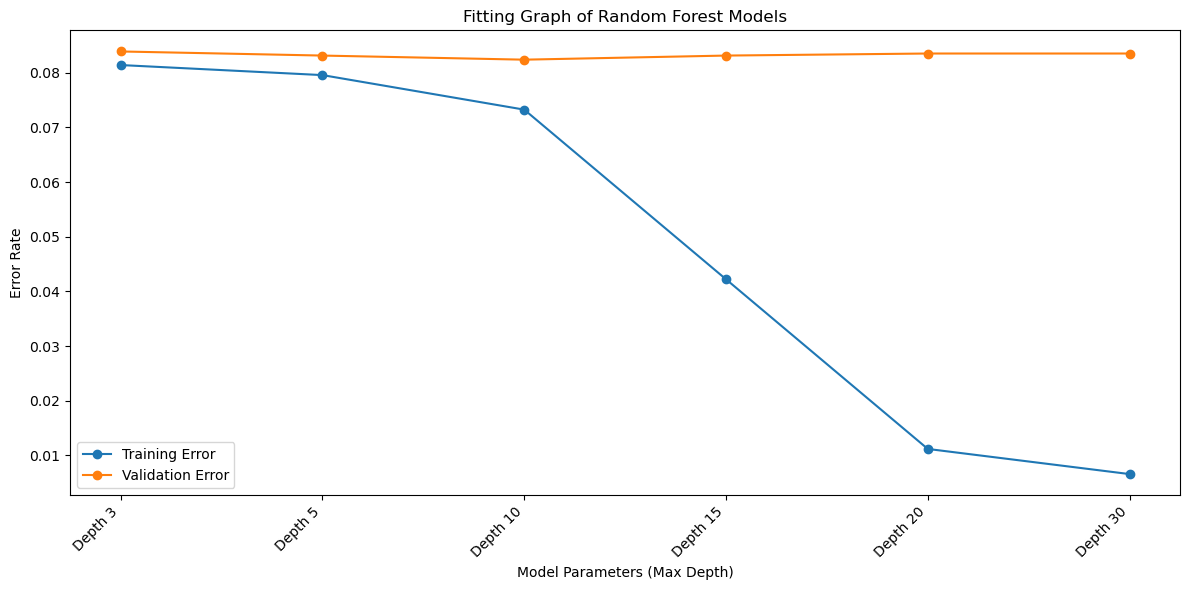

In [56]:
# Gets results for plot
parameters = [r['parameters'] for r in results]
train_errors = [r['train_error'] for r in results]
val_errors = [r['val_error'] for r in results]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(parameters, train_errors, label='Training Error', marker='o')
plt.plot(parameters, val_errors, label='Validation Error', marker='o')
plt.xlabel('Model Parameters (Max Depth)')
plt.ylabel('Error Rate')
plt.title('Fitting Graph of Random Forest Models')
plt.xticks(rotation=45, ha = 'right')
plt.legend()
plt.tight_layout()
plt.show()

#### Results

In [57]:
# Add in validation data for the full test
train_data_full = train_data.union(validation_data)

In [58]:
# Best performance comes from a tree depth of 10
rf_10 = RandomForestClassifier(featuresCol="features",
                               labelCol="safe?",
                               maxDepth=10,
                               seed = 42)
model_10 = rf_10.fit(train_data_full)

In [59]:
# Retreives the prediction dfs and errors for each split
# Adds a column specifying the dataset
train_predictions = model_10.transform(train_data_full).withColumn("dataset", f.lit("Train"))
train_error = 1 - evaluator.evaluate(train_predictions)
test_predictions = model_10.transform(test_data).withColumn("dataset", f.lit("Test"))
test_error = 1 - evaluator.evaluate(test_predictions)

In [60]:
# Prints the error rate for each dataset
print(f"Train Error: {train_error}")
print(f"Test Error: {test_error}")

Train Error: 0.07647493989273169
Test Error: 0.07627604664500098


In [61]:
# Creates a groundtruth dataframe to show the accuracy of the predictions
train_pred_safe = train_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
train_pred_unsafe = train_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
test_pred_safe = test_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
test_pred_unsafe = test_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
ground_df = sc.createDataFrame([train_pred_safe, 
                                train_pred_unsafe,
                                test_pred_safe,
                                test_pred_unsafe])

In [62]:
# Ground truth df
ground_df.withColumn("correct", f.when(f.col('safe?') == f.col('prediction'), True).otherwise(False)).show()

+-------+--------------------+-----+----------+-------+
|dataset|            features|safe?|prediction|correct|
+-------+--------------------+-----+----------+-------+
|  Train|(28,[0,1,2,3,4,5,...|    1|       1.0|   true|
|  Train|(28,[0,1,2,3,4,5,...|    0|       1.0|  false|
|   Test|(28,[0,1,2,3,4,5,...|    1|       1.0|   true|
|   Test|(28,[0,1,2,3,4,5,...|    0|       1.0|  false|
+-------+--------------------+-----+----------+-------+



#### Confusion Matrix

In [63]:
# Creates RDD from test predictions for making a confusion matrix
predictionAndLabels = test_predictions.select(f.col("prediction"), f.col("safe?"))
predictionAndLabelsRDD = predictionAndLabels.rdd.map(lambda x: (float(x[0]), float(x[1])))

In [64]:
# Produces a confusion matrix pandas dataframe
metrics = MulticlassMetrics(predictionAndLabelsRDD)
confusionMatrix = metrics.confusionMatrix().toArray()
confusion_df = pd.DataFrame(confusionMatrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

/usr/local/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


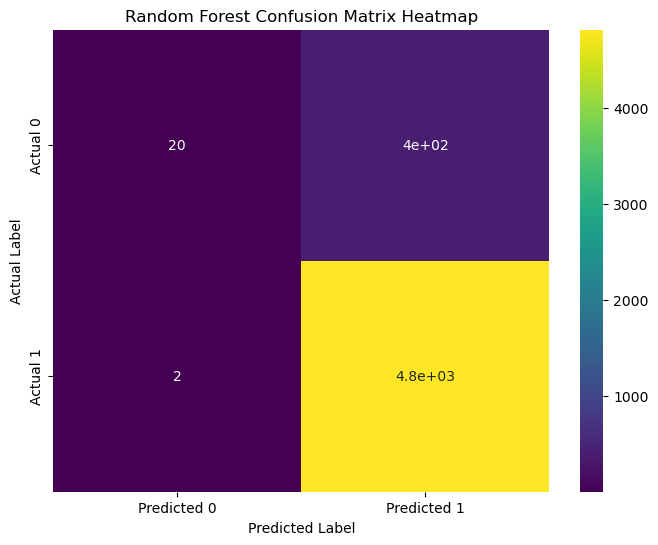

In [65]:
# Shows off confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, cmap="viridis")
plt.title("Random Forest Confusion Matrix Heatmap")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#### Feature Importance

In [66]:
# Returns the most important features for our random forest model
importances = model_10.featureImportances
importance_list = importances.toArray()
for i, importance in enumerate(importance_list):
    print(f"Feature {features[i]}: {importance}")

Feature avg_shoredistance: 0.05703684061228983
Feature avg_bathymetry: 0.056844856924037755
Feature avg_sst: 0.0514906271202406
Feature avg_sss: 0.04658989232273319
Feature sum_count: 0.03801917900275709
Feature log_sum_count: 0.0306722084525462
Feature marine: 0.0044017861317936025
Feature brackish: 0.00596574762655146
Feature freshwater: 0.003040219253404635
Feature terrestrial: 0.010487740970934472
Feature moving_avg_sst: 0.05843165649336276
Feature rolling_stddev_sst: 0.047266507223734426
Feature yoy_change_avg_sst: 0.03405351658186438
Feature moving_avg_sss: 0.052991961018092004
Feature rolling_stddev_sss: 0.05352058940588261
Feature yoy_change_avg_sss: 0.02641191155216536
Feature moving_avg_sum_cnt: 0.036503380735633154
Feature rolling_stddev_sum_cnt: 0.037405964899385614
Feature yoy_change_sum_cnt: 0.022475537854030517
Feature moving_avg_log_cnt: 0.0523356119278679
Feature rolling_stddev_log_cnt: 0.034826583960166795
Feature yoy_change_log_cnt: 0.026990063780131465
Feature diffe

In [67]:
# Converts feature importance pairs into a list
feature_importance_pairs = list(zip(features, importance_list))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
sorted_features, sorted_importance_list = zip(*feature_importance_pairs)

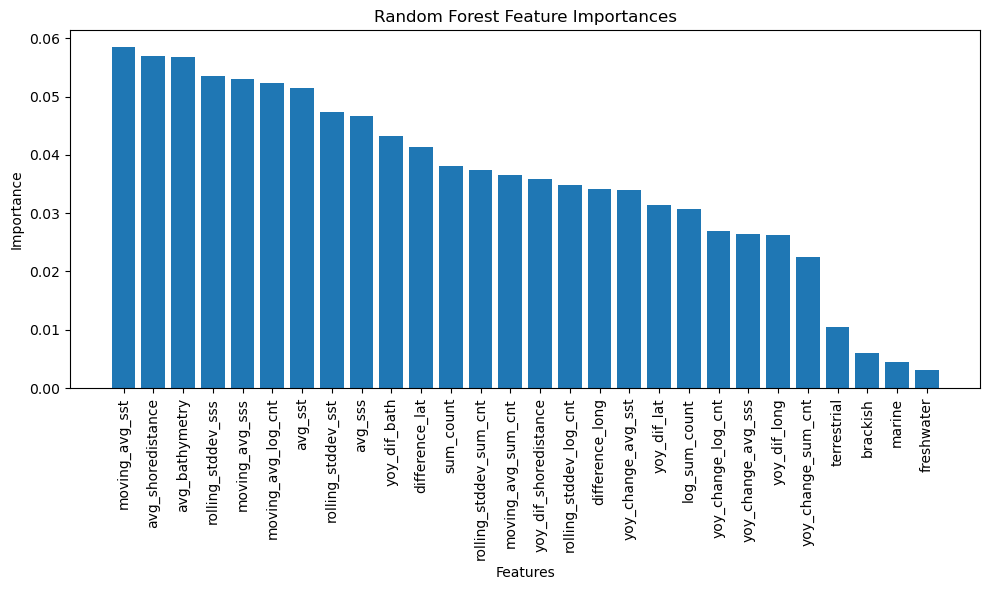

In [68]:
# Plots the feature importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importance_list)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Model 1b: Random Forest v2

#### Data Setup

In [69]:
# Removing excess 'safe?' == 1 rows as there is an inbalance in the data
df_temporal_notsafe_rf = df_temporal.filter(f.col('safe?')==0)
df_temporal_safe_rf = df_temporal.filter(f.col('safe?')==1)
df_temporal_safe_rf = df_temporal_safe_rf.sample(False, fraction=0.0888, seed=42)
df_temporal_rfv2 = df_temporal_safe_rf.union(df_temporal_notsafe_rf).withColumn("safe?", f.col("safe?").cast("int")).fillna(0)

In [70]:
# Using the data we setup earlier with some features removed
# Found that with scaling the log values were detrimental to our model
# Found that the enrironment type was also detrimental
# Selecting which features we want
features = [
 'avg_shoredistance',
 'avg_bathymetry',
 'avg_sst',
 'avg_sss',
 'sum_count',
 'moving_avg_sst',
 'rolling_stddev_sst',
 'yoy_change_avg_sst',
 'moving_avg_sss',
 'rolling_stddev_sss',
 'yoy_change_avg_sss',
 'moving_avg_sum_cnt',
 'rolling_stddev_sum_cnt',
 'yoy_change_sum_cnt',
 'difference_long',
 'difference_lat',
 'yoy_dif_lat',
 'yoy_dif_long',
 'yoy_dif_shoredistance',
 'yoy_dif_bath']

# Sets up the vector assembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Transforms data via assembler
df_rfv2_vector = assembler.transform(df_temporal_rfv2)

In [71]:
# Scaling based on min max scale as standard scaler did not prove effective
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Creates a scaler model
scaler_model_rf = scaler.fit(df_rfv2_vector)

# Transforms the feature column using the scaler model
df_scaled_rfv2 = scaler_model_rf.transform(df_rfv2_vector)

In [72]:
#Splits up the data
train_data_rf2, validation_data_rf2, test_data_rf2 = df_scaled_rfv2.select('safe?', 'scaled_features').randomSplit([0.6, 0.2, 0.2], seed=42)
train_data_rf2 = train_data_rf2.cache()
validation_data_rf2 = validation_data_rf2.cache()
test_data_rf2 = test_data_rf2.cache()

#### Fitting Graph

In [73]:
# Similarly performed a grid search during the fitting graph creation, and found similar results to model 1a
# Found from testing that the number of trees had little affect
# Used depth as our base for the fitting graph

# Hyperparamters
# numTrees_list = [10, 20, 50, 100]
maxDepth_list = [3, 5, 10, 15, 20, 30]

# Evaluator set up
evaluator = MulticlassClassificationEvaluator(labelCol="safe?", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

# Looping over each hyperparamter and returning the results
results = []
for depth in maxDepth_list:
    # Setting up rf model
    rf = RandomForestClassifier(featuresCol="scaled_features", 
                                labelCol="safe?", 
                                # numTrees=num, 
                                maxDepth=depth,
                                seed = 42)
    # Training the rf model
    model = rf.fit(train_data_rf2)
    # Evaluating the training data
    train_predictions = model.transform(train_data_rf2)
    train_accuracy = evaluator.evaluate(train_predictions)
    # Evaluating the validation data
    val_predictions = model.transform(validation_data_rf2)
    val_accuracy = evaluator.evaluate(val_predictions)
    # Store the results including error rates
    results.append({
        'parameters': f"Depth {depth}",
        'train_error': 1 - train_accuracy,
        'val_error': 1 - val_accuracy
    })

# Returns errors
for result in results:
    print(result)

{'parameters': 'Depth 3', 'train_error': 0.3696231442710316, 'val_error': 0.4105145413870246}
{'parameters': 'Depth 5', 'train_error': 0.3011039208222307, 'val_error': 0.3814317673378076}
{'parameters': 'Depth 10', 'train_error': 0.08450704225352113, 'val_error': 0.31431767337807603}
{'parameters': 'Depth 15', 'train_error': 0.00989722116482683, 'val_error': 0.3400447427293065}
{'parameters': 'Depth 20', 'train_error': 0.004567948229920016, 'val_error': 0.3512304250559284}
{'parameters': 'Depth 30', 'train_error': 0.004567948229920016, 'val_error': 0.35794183445190153}


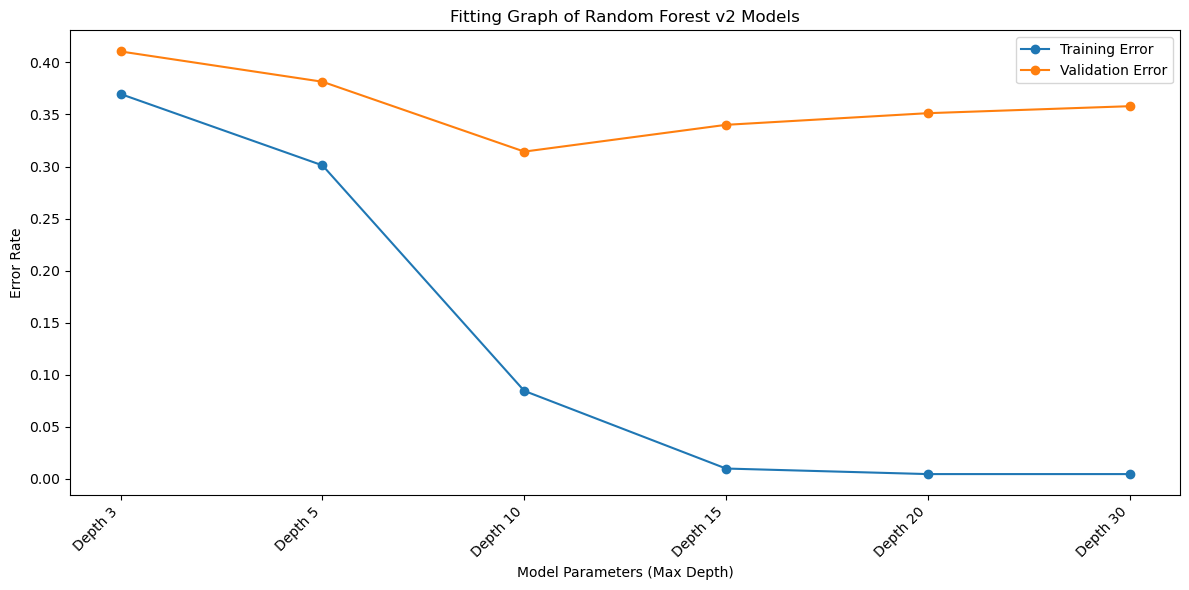

In [74]:
# Gets results for plot
parameters = [r['parameters'] for r in results]
train_errors = [r['train_error'] for r in results]
val_errors = [r['val_error'] for r in results]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(parameters, train_errors, label='Training Error', marker='o')
plt.plot(parameters, val_errors, label='Validation Error', marker='o')
plt.xlabel('Model Parameters (Max Depth)')
plt.ylabel('Error Rate')
plt.title('Fitting Graph of Random Forest v2 Models')
plt.xticks(rotation=45, ha = 'right')
plt.legend()
plt.tight_layout()
plt.show()

#### Results

In [75]:
# Add in validation data for the full test
train_data_rf2_full = train_data_rf2.union(validation_data_rf2)

In [76]:
# Best performance comes from a tree depth of 10
rfv2_10 = RandomForestClassifier(featuresCol="scaled_features",
                               labelCol="safe?",
                               maxDepth=10,
                               seed = 42)
modelv2_10 = rfv2_10.fit(train_data_rf2_full)

In [77]:
# Retreives the prediction dfs and errors for each split
# Adds a column specifying the dataset
train_predictions = modelv2_10.transform(train_data_rf2_full).withColumn("dataset", f.lit("Train"))
train_error = 1 - evaluator.evaluate(train_predictions)
test_predictions = modelv2_10.transform(test_data_rf2).withColumn("dataset", f.lit("Test"))
test_error = 1 - evaluator.evaluate(test_predictions)

In [78]:
# Prints the error rate for each dataset
print(f"Train Error: {train_error}")
print(f"Test Error: {test_error}")

Train Error: 0.10025560920193122
Test Error: 0.32366589327146167


In [79]:
# Creates a groundtruth dataframe to show the accuracy of the predictions
train_pred_safe = train_predictions.select('dataset','scaled_features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
train_pred_unsafe = train_predictions.select('dataset','scaled_features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
test_pred_safe = test_predictions.select('dataset','scaled_features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
test_pred_unsafe = test_predictions.select('dataset','scaled_features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
ground_df = sc.createDataFrame([train_pred_safe, 
                                train_pred_unsafe,
                                test_pred_safe,
                                test_pred_unsafe])

In [80]:
# Ground truth df
ground_df.withColumn("correct", f.when(f.col('safe?') == f.col('prediction'), True).otherwise(False)).show()

+-------+--------------------+-----+----------+-------+
|dataset|     scaled_features|safe?|prediction|correct|
+-------+--------------------+-----+----------+-------+
|  Train|[0.01276865615754...|    1|       1.0|   true|
|  Train|[0.01202186166528...|    0|       0.0|   true|
|   Test|[0.01277684005582...|    1|       1.0|   true|
|   Test|[0.01513346275037...|    0|       1.0|  false|
+-------+--------------------+-----+----------+-------+



#### Confusion Matrix

In [81]:
# Creates RDD from test predictions for making a confusion matrix
predictionAndLabels = test_predictions.select(f.col("prediction"), f.col("safe?"))
predictionAndLabelsRDD = predictionAndLabels.rdd.map(lambda x: (float(x[0]), float(x[1])))

In [82]:
# Produces a confusion matrix pandas dataframe
metrics = MulticlassMetrics(predictionAndLabelsRDD)
confusionMatrix = metrics.confusionMatrix().toArray()
confusion_df = pd.DataFrame(confusionMatrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

/usr/local/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


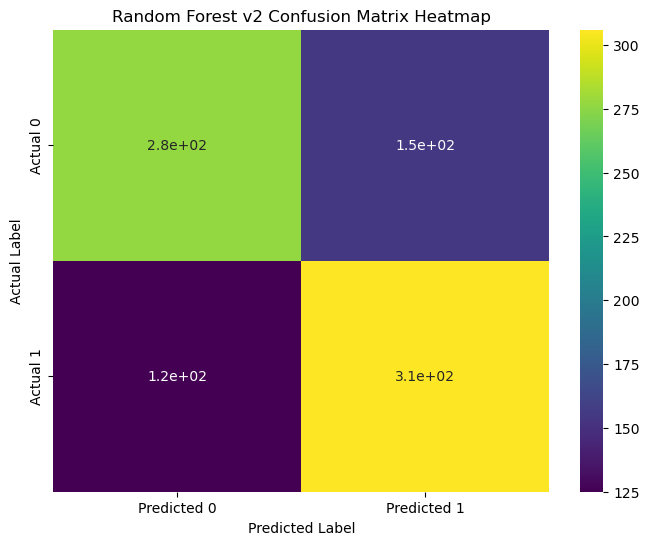

In [83]:
# Shows off confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, cmap="viridis")
plt.title("Random Forest v2 Confusion Matrix Heatmap")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#### Feature Importance

In [84]:
# Returns the most important features for our random forest v2 classifier model
importances = modelv2_10.featureImportances
importance_list = importances.toArray()
for i, importance in enumerate(importance_list):
    print(f"Feature {features[i]}: {importance}")

Feature avg_shoredistance: 0.07251469520331419
Feature avg_bathymetry: 0.056717657998437
Feature avg_sst: 0.05827977408811681
Feature avg_sss: 0.05219978874004351
Feature sum_count: 0.04720176792993047
Feature moving_avg_sst: 0.07491767966419666
Feature rolling_stddev_sst: 0.04420965037238446
Feature yoy_change_avg_sst: 0.03932131067501
Feature moving_avg_sss: 0.05138616281078825
Feature rolling_stddev_sss: 0.05242614714746576
Feature yoy_change_avg_sss: 0.03897484013046379
Feature moving_avg_sum_cnt: 0.06469008872862284
Feature rolling_stddev_sum_cnt: 0.045424597859194796
Feature yoy_change_sum_cnt: 0.037076837442903465
Feature difference_long: 0.05776263134738698
Feature difference_lat: 0.04622938461057929
Feature yoy_dif_lat: 0.03173588684044194
Feature yoy_dif_long: 0.03255308429305591
Feature yoy_dif_shoredistance: 0.04255314001391353
Feature yoy_dif_bath: 0.053824874103750364


In [85]:
# Converts feature importance pairs into a list
feature_importance_pairs = list(zip(features, importance_list))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
sorted_features, sorted_importance_list = zip(*feature_importance_pairs)

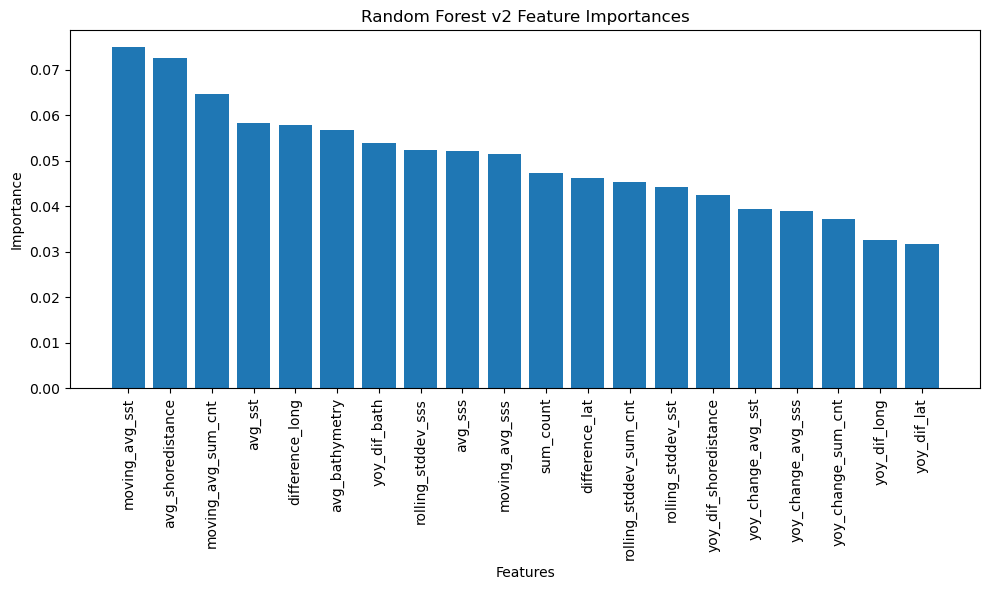

In [86]:
# Plots the feature importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importance_list)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest v2 Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Model 2: GBT Classifier

#### Data Setup

In [87]:
# Cleans features of data that can't be ingested into an gbt model
df_temporal_gbt = df_temporal.withColumn("safe?", f.col("safe?").cast("int")).fillna(0)

In [88]:
# Removing excess 'safe?' == 1 rows a there is an inbalance in the data
df_temporal_notsafe_gbt = df_temporal_gbt.filter(f.col('safe?')==0)
df_temporal_safe_gbt = df_temporal_gbt.filter(f.col('safe?')==1)
df_temporal_safe_gbt = df_temporal_safe_gbt.sample(False, fraction=0.0888, seed=42)
df_temporal_gbt = df_temporal_safe_gbt.union(df_temporal_notsafe_gbt)

In [89]:
# Selecting which features we want
# Removed environmental type as they had lower importance
# Did not select log counts since we are applying a scaler
features = [
 'avg_shoredistance',
 'avg_bathymetry',
 'avg_sst',
 'avg_sss',
 'sum_count',
 'moving_avg_sst',
 'rolling_stddev_sst',
 'yoy_change_avg_sst',
 'moving_avg_sss',
 'rolling_stddev_sss',
 'yoy_change_avg_sss',
 'moving_avg_sum_cnt',
 'rolling_stddev_sum_cnt',
 'yoy_change_sum_cnt',
 'difference_long',
 'difference_lat',
 'yoy_dif_lat',
 'yoy_dif_long',
 'yoy_dif_shoredistance',
 'yoy_dif_bath']

# Sets up the vector assembler
assembler_gbt = VectorAssembler(inputCols=features, outputCol='features')

# Transforms data via assembler
df_gbt_vector = assembler_gbt.transform(df_temporal_gbt)

In [90]:
# Scaling based on min max scale as standard scaler did not prove effective
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Creates a scaler model
scaler_model_gbt = scaler.fit(df_gbt_vector)

# Transforms the featuree column using the scaler model
df_scaled_gbt = scaler_model_gbt.transform(df_gbt_vector)

In [91]:
# Splits up the data
train_data_gbt, validation_data_gbt, test_data_gbt = df_scaled_gbt.select('safe?', 'scaled_features').randomSplit([0.6, 0.2, 0.2], seed=42)
train_data_gbt = train_data_gbt.cache()
validation_data_gbt = validation_data_gbt.cache()
test_data_gbt = test_data_gbt.cache()

#### Fitting Graph

In [92]:
# Performed grid search of the gbt classifier model during the creation of the fitting graph
# Found from testing that maxDepth similarly had the greatest effect on the model, so it will be used to generate the fitting graph

# Hyperparamters
maxDepth_list = [3, 5, 10, 15, 20, 30]
# maxIter_list = [10, 20, 30, 50, 100, 150, 200]
# stepSize_list = [0.01, 0.05, 0.1, 0.2, 0.3]


# Evaluator set up (same as before)
evaluator = MulticlassClassificationEvaluator(labelCol='safe?', 
                                              predictionCol='prediction', 
                                              metricName='accuracy')

# Looping over each hyperparamter and returning the results
gbt_results = []
for depth in maxDepth_list:
    # Setting up gbt model
    gbt = GBTClassifier(labelCol='safe?', 
                        featuresCol='scaled_features',
                        maxDepth=depth,
                        maxIter=150,
                        stepSize=0.1,
                        seed=42)
    
    # Training the gbt model
    model_gbt = gbt.fit(train_data_gbt)
    
    # Evaluating the training data
    train_predictions = model_gbt.transform(train_data_gbt)
    train_accuracy = evaluator.evaluate(train_predictions)
    # Evaluating the validation data
    val_predictions = model_gbt.transform(validation_data_gbt)
    val_accuracy = evaluator.evaluate(val_predictions)
    # Store the results including error rates
    gbt_results.append({
        'parameters': f"Depth {depth}",
        'train_error': 1 - train_accuracy,
        'val_error': 1 - val_accuracy
    })

# Returns errors
for result in gbt_results:
    print(result)

{'parameters': 'Depth 3', 'train_error': 0.1465550057099353, 'val_error': 0.33221476510067116}
{'parameters': 'Depth 5', 'train_error': 0.019033117624666973, 'val_error': 0.31543624161073824}
{'parameters': 'Depth 10', 'train_error': 0.003806623524933439, 'val_error': 0.34787472035794187}
{'parameters': 'Depth 15', 'train_error': 0.003806623524933439, 'val_error': 0.3657718120805369}
{'parameters': 'Depth 20', 'train_error': 0.003806623524933439, 'val_error': 0.3803131991051454}
{'parameters': 'Depth 30', 'train_error': 0.003806623524933439, 'val_error': 0.3803131991051454}


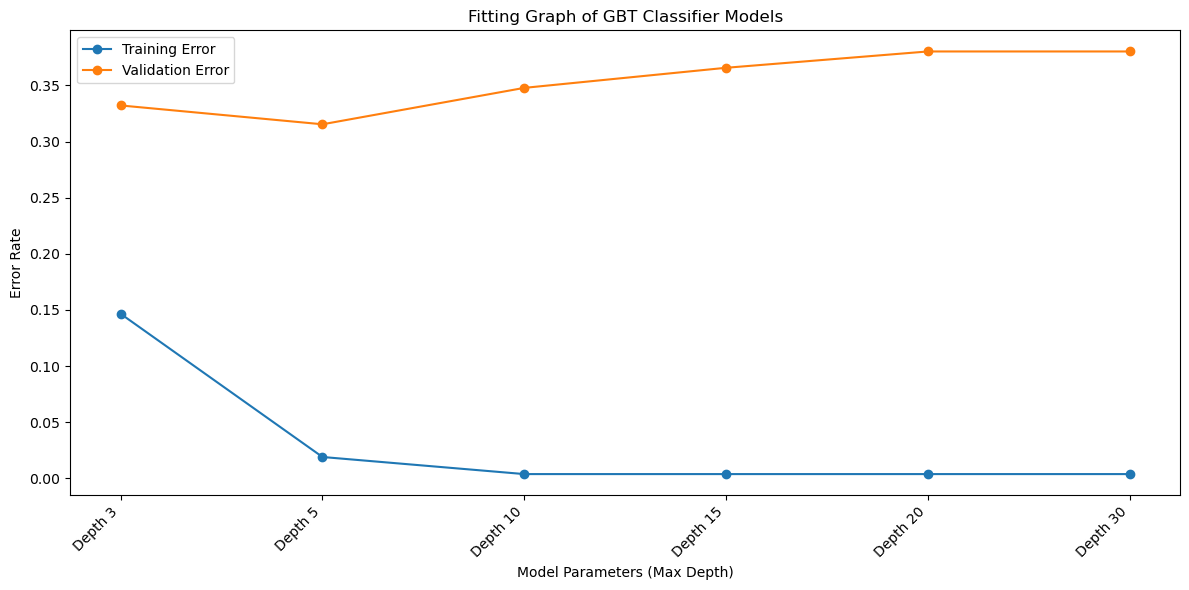

In [93]:
# Gets results for plot
parameters = [r['parameters'] for r in gbt_results]
train_errors = [r['train_error'] for r in gbt_results]
val_errors = [r['val_error'] for r in gbt_results]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(parameters, train_errors, label='Training Error', marker='o')
plt.plot(parameters, val_errors, label='Validation Error', marker='o')
plt.xlabel('Model Parameters (Max Depth)')
plt.ylabel('Error Rate')
plt.title('Fitting Graph of GBT Classifier Models')
plt.xticks(rotation=45, ha = 'right')
plt.legend()
plt.tight_layout()
plt.show()

#### Results

In [94]:
# Add in validation data for the full test
train_data_gbt_full = train_data_gbt.union(validation_data_gbt)

In [95]:
# Best performance comes from a tree depth of 5
gbt_5 = GBTClassifier(labelCol='safe?', 
                      featuresCol='scaled_features',
                      maxDepth=5,
                      maxIter=150,
                      stepSize=0.1,
                      seed=42)
model_5 = gbt_5.fit(train_data_gbt_full)

In [96]:
# Retreives the prediction dfs and errors for each split
# Adds a column specifying the dataset
train_predictions = model_5.transform(train_data_gbt_full).withColumn("dataset", f.lit("Train"))
train_error = 1 - evaluator.evaluate(train_predictions)
test_predictions = model_5.transform(test_data_gbt).withColumn("dataset", f.lit("Test"))
test_error = 1 - evaluator.evaluate(test_predictions)

In [97]:
# Prints the error rate for each dataset
print(f"Train Error: {train_error}")
print(f"Test Error: {test_error}")

Train Error: 0.028117012212439674
Test Error: 0.3190255220417634


In [98]:
# Creates a groundtruth dataframe to show the accuracy of the predictions
train_pred_safe = train_predictions.select('dataset','scaled_features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
train_pred_unsafe = train_predictions.select('dataset','scaled_features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
test_pred_safe = test_predictions.select('dataset','scaled_features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
test_pred_unsafe = test_predictions.select('dataset','scaled_features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
ground_df = sc.createDataFrame([train_pred_safe, 
                                train_pred_unsafe,
                                test_pred_safe,
                                test_pred_unsafe])

In [99]:
# Ground truth df
ground_df.withColumn("correct", f.when(f.col('safe?') == f.col('prediction'), True).otherwise(False)).show()

+-------+--------------------+-----+----------+-------+
|dataset|     scaled_features|safe?|prediction|correct|
+-------+--------------------+-----+----------+-------+
|  Train|[0.01276865615754...|    1|       1.0|   true|
|  Train|[0.01202186166528...|    0|       0.0|   true|
|   Test|[0.01277684005582...|    1|       1.0|   true|
|   Test|[0.01513346275037...|    0|       1.0|  false|
+-------+--------------------+-----+----------+-------+



#### Confusion Matrix

In [100]:
# Creates RDD from test predictions for making a confusion matrix
predictionAndLabels = test_predictions.select(f.col("prediction"), f.col("safe?"))
predictionAndLabelsRDD = predictionAndLabels.rdd.map(lambda x: (float(x[0]), float(x[1])))

In [101]:
# Produces a confusion matrix pandas dataframe
metrics = MulticlassMetrics(predictionAndLabelsRDD)
confusionMatrix = metrics.confusionMatrix().toArray()
confusion_df = pd.DataFrame(confusionMatrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

/usr/local/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


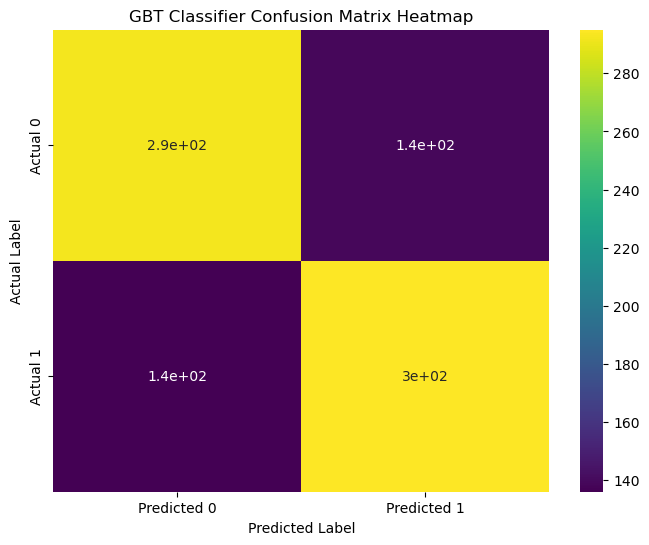

In [102]:
# Shows off confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, cmap="viridis")
plt.title("GBT Classifier Confusion Matrix Heatmap")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#### Feature Importance

In [103]:
# Returns the most important features for our gbt classifier model
importances = model_5.featureImportances
importance_list = importances.toArray()
for i, importance in enumerate(importance_list):
    print(f"Feature {features[i]}: {importance}")

Feature avg_shoredistance: 0.07774284569250038
Feature avg_bathymetry: 0.06493511061212874
Feature avg_sst: 0.0552028987363447
Feature avg_sss: 0.05037338876495907
Feature sum_count: 0.04500463919324626
Feature moving_avg_sst: 0.06342204734704733
Feature rolling_stddev_sst: 0.06875555144893601
Feature yoy_change_avg_sst: 0.049650966012911725
Feature moving_avg_sss: 0.05235757343561529
Feature rolling_stddev_sss: 0.05832164042323953
Feature yoy_change_avg_sss: 0.042208121328475935
Feature moving_avg_sum_cnt: 0.05208242765399502
Feature rolling_stddev_sum_cnt: 0.043732513578743984
Feature yoy_change_sum_cnt: 0.030185276715882576
Feature difference_long: 0.040986811271542335
Feature difference_lat: 0.0426846846295702
Feature yoy_dif_lat: 0.03329590186171228
Feature yoy_dif_long: 0.037954976774502054
Feature yoy_dif_shoredistance: 0.04695922496816015
Feature yoy_dif_bath: 0.04414339955048639


In [104]:
# Converts feature importance pairs into a list
feature_importance_pairs = list(zip(features, importance_list))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
sorted_features, sorted_importance_list = zip(*feature_importance_pairs)

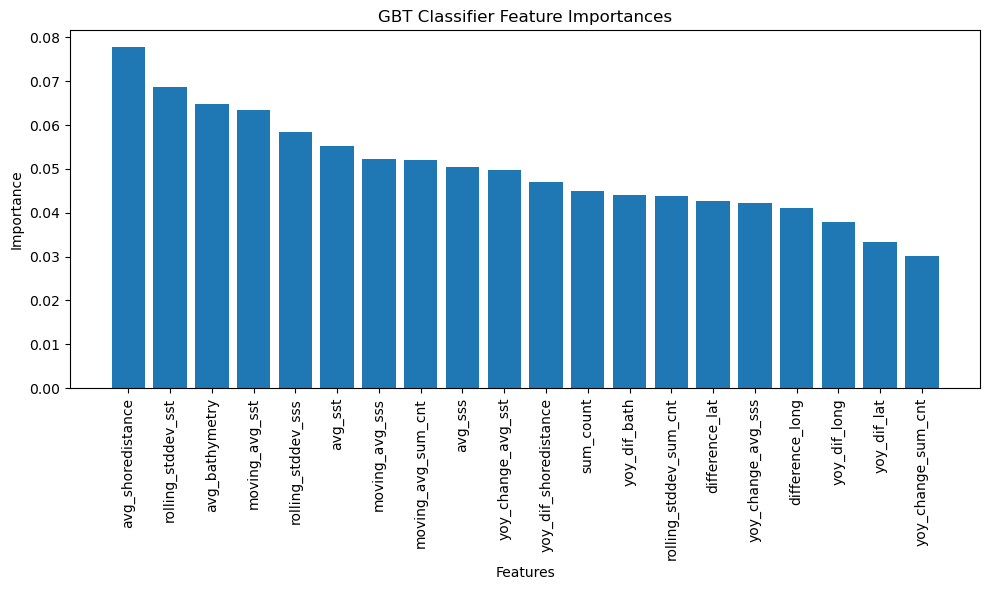

In [105]:
# Plots the feature importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importance_list)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('GBT Classifier Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()